In [2]:
import flybrainlab as fbl
import os
%load_ext autoreload
%autoreload 2
print(os.getcwd())

/home/e6095/ffbo/neurodriver/examples/code-generation/Neuropiler


## Testing LeakyIAF Neuron

In [15]:
# User-defined model goes here
def mymodel():
    class myLeakyIAF(BaseAxonHillockModel):
        updates = ['spike', # (bool)
                   'V' # Membrane Potential (mV)
                  ]
        accesses = ['I'] # (\mu A/cm^2 )
        params = ['resting_potential', # (mV)
                  'threshold', # Firing Threshold (mV)
                  'reset_potential', # Potential to be reset to after a spike (mV)
                  'capacitance', # (\mu F/cm^2)
                  'resistance' # (k\Omega cm.^2)
                  ]
        internals = OrderedDict([('internalV', 0.0)]) # Membrane Potential (mV)
        localvars = ['bh']

        def step():
            bh = exp(-dt/capacitance/resistance)

            for i in range(n_steps):
                V = V*bh + (resistance*I+resting_potential)*(1.0 - bh) 
                if V > threshold:
                    V = reset_potential
                    spike = 1.

In [16]:
# Get source code of user model 
import inspect
lines = inspect.getsource(mymodel)
lines = lines.replace('def mymodel():','')
lines = lines.replace('\n    ','\n')
with open("usermodel.py", "w") as python_code:
    python_code.write(lines)

# Give the user model to Neuropiler
import os
if os.system("python neuropile.py ./usermodel.py"):
    print('Code generation FAILED')
else:
    print('Code generation SUCCESS')
    print('Model saved in file <classname>_gen.py')

Code generation SUCCESS
Model saved in file <classname>_gen.py


In [4]:
from neuroballad import *
%load_ext autoreload
%autoreload 2

dur = 1.
dt = 1e-4

C = Circuit()
neu_id = 0
C.add([neu_id], myLeakyIAF())
C_in = InIStep(neu_id, 1., 0.20, 0.40, var='I')
C.sim(dur, dt, [C_in], record = ['V','spike_state','I'])
sim_results = C.collect_results()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
I/uids
[('V', None), ('spike_state', None), ('I', None)]


In [5]:
f = h5py.File('neuroballad_temp_model_output.h5', 'r')
print([a for a in f])
f.close()

['I', 'V', 'metadata', 'spike_state']


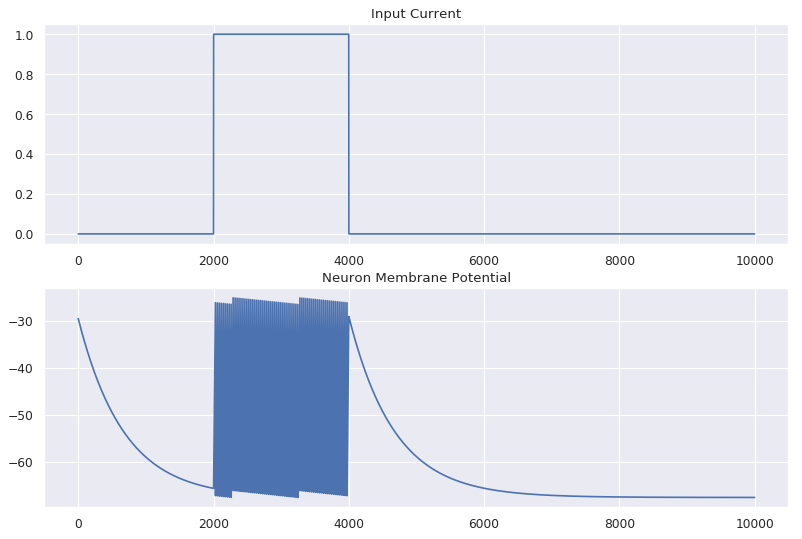

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
f = h5py.File('neuroballad_temp_model_output.h5', 'r')
plt.figure(figsize=(12, 8), dpi=80)
plt.subplot(211)
plt.plot(f['I']['data'])
plt.title('Input Current')
plt.subplot(212)
plt.plot(f['V']['data'])
plt.title('Neuron Membrane Potential')
plt.show()
f.close()

## Testing Alpha Synapse

In [34]:
def mymodel():
    class myAlphaSynapse(BaseSynapseModel):
        updates = ['g']
        accesses = ['spike_state']
        params = ['gmax',
                  'ar',
                  'ad']
        internals = OrderedDict([('z', 0.0),  # g,
                             ('dz', 0.0),  # derivative of g
                             ('d2z', 0.0)  # second derivative of g
                             ])
        localvars = ['new_z','new_dz','new_d2z']

        def step():
            for i in range(n_steps):
                new_z = fmax( 0., z + dt*dz )
                new_dz = dz + dt*d2z
                if spike_state>0.:
                    new_dz = new_dz + ar*ad
                new_d2z = -( ar+ad )*dz - ar*ad*z
                z = new_z
                dz = new_dz
                d2z = new_d2z
            g = new_z*gmax

In [35]:
# Get source code of user model 
import inspect
lines = inspect.getsource(mymodel)
lines = lines.replace('def mymodel():','')
lines = lines.replace('\n    ','\n')
with open("usermodel.py", "w") as python_code:
    python_code.write(lines)

# Give the user model to Neuropiler
import os
if os.system("python neuropile.py ./usermodel.py"):
    print('Code generation FAILED')
else:
    print('Code generation SUCCESS')
    print('Model saved in file <classname>_gen.py')

Code generation SUCCESS
Model saved in file <classname>_gen.py


In [29]:
from neuroballad import *
%load_ext autoreload
%autoreload 2

dur = 1.
dt = 1e-4

C = Circuit()
neu_id = 0
C.add([neu_id], myAlphaSynapse())

# C_in = InIStep(neu_id, 1., 0.2, 0.2+2*dt, var='spike_state')
C_in = InSpike(neu_id, 0.04, var='spike_state')
C.sim(dur, dt, [C_in], record = ['spike_state','g'])
sim_results = C.collect_results()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
spike_state/uids
[('spike_state', None), ('g', None)]


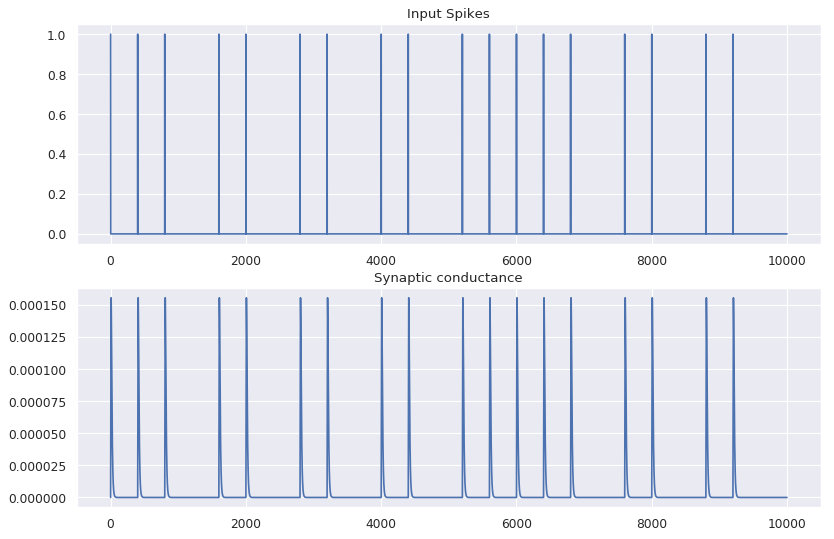

In [33]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
f = h5py.File('neuroballad_temp_model_output.h5', 'r')
plt.figure(figsize=(12, 8), dpi=80)
plt.subplot(211)
plt.plot(f['spike_state']['data'])
plt.title('Input Spikes')
plt.subplot(212)
plt.plot(f['g']['data'])
plt.title('Synaptic conductance')
plt.show()
f.close()